# 1D Elastic displacement (mixed formulation)

## Problem description

Consider a beam of thickness $H$ loaded with some force $f = f(x)$. Let $\eta = \eta(x)$ represent the vertical deflection of the beam in response to $f$, with $M = M(x)$ the associated bending moment. Define $\lambda := \frac{E}{12(1 - \mu^2)}$, where $E$ is Young's Modulus and $\mu$ is Poisson's Ratio. Then the governing equation and constitutive relation on the plate are:

$$
-M'' = f
$$

$$
M = -H^3\lambda\eta''.
$$ 

Let $n$ and $m$ be arbitrary functions in $x$. From the product rule and the Fundamental Theorem of Calculus, it can be derived that the corresponding weak forms for these equations are:

$$
\int_xm'M' - [mM']_{x_0}^{x_1} = \int_xmf
$$

$$
\int_xnM = \int_x(H^3\lambda n)'\eta' - [H^3\lambda n\eta']_{x_0}^{x_1}
$$

Consequently, define

$$ 
a := \int_xm'M' + \int_xnM - \int_x(H^3\lambda n)'\eta'
$$

$$
L := \int_xmf.
$$


The task is now to find $(M, \eta)$ such that $a = L$ for every $(n, m)$. 

## Imports

In [1]:
from firedrake import *
import matplotlib.pyplot as plt
import numpy as np

## Meshing and material parameters

In [2]:
nx = 100 #number of nodes
Lx = 10 #length of mesh in meters
H = 2 #thickness of the bar in meters
mesh = IntervalMesh(nx, Lx)

Q1 = FunctionSpace(mesh, 'CG', 2) #this will be η's function space
Q2 = FunctionSpace(mesh, 'CG', 2) #and M's function space
Q = Q1*Q2 #mixed function space for (η, M)

η, M = TrialFunctions(Q) #deflection η, moment M_xx
n, m = TestFunctions(Q)

x = SpatialCoordinate(mesh)
X = np.arange(0, Lx + 1/nx, 1/nx) #for plotting later

ρ_i = 917 #density of ice (kg/m^3)
g = 9.81 #gravitational constant (N/kg)
E = 1e9 #Young's Modulus (Pa)
μ = 1/3 #Poisson's Ratio
λ = E/(12*(1 - μ**2))

## Set up and solve the problem

We'll consider a bar with zero displacement and zero bending moment at both ends, so that $\eta = M = 0$ on boundaries 1 and 2. These boundaries will be enforced using Firedrake's built-in ```DirichletBC```. 

In [3]:
a = (grad(m)[0]*grad(M)[0])*dx + (n*M)*dx - (grad(H**3*λ*n)[0]*grad(η)[0])*dx
L = (-ρ_i*g*H*m)*dx

bc_η = DirichletBC(Q.sub(0), Constant(0), (1, 2)) #η = 0 on dS
bc_M = DirichletBC(Q.sub(1), Constant(0), (1, 2)) #M = 0 on dS

q = Function(Q) # q = (η, M)
solve(a == L, q, bcs = [bc_η, bc_M])

## Plot, and compare with the analytic solution

The analytic solutions for the deflection and the bending moment are 

$$
\eta = -\frac{\rho_ig(1 - \mu^2)}{H^2E}\left(\frac{1}{2}x^4 - Lx^3 + \frac{1}{2}L^3x\right)
$$

$$
M = \frac{1}{2}\rho_igH(x^2 - Lx)
$$

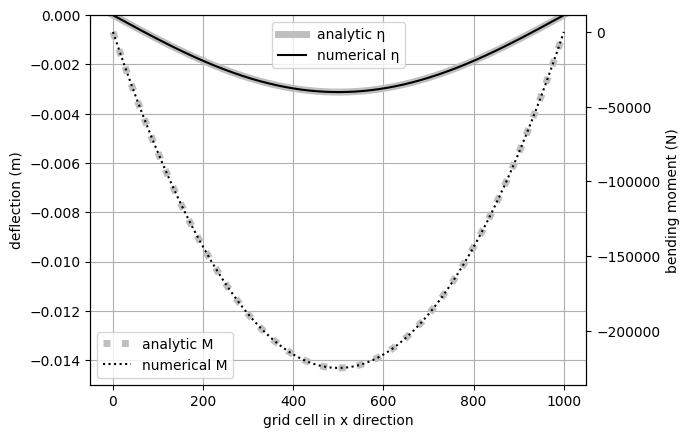

In [4]:
analytic_η_profile = -ρ_i*g*(1 - μ**2)/(H**2*E)*(1/2*X**4 - Lx*X**3 + 1/2*Lx**3*X)
analytic_M_profile = 1/2*ρ_i*g*H*(X**2 - Lx*X)

modeled_η_profile = Function(Q2).project(q[0]).at(X, tolerance = 1e-10)
modeled_M_profile = Function(Q1).project(q[1]).at(X, tolerance = 1e-10)

plt.figure()
plt.plot(analytic_η_profile, color = '0.75', linewidth = 5, label = 'analytic η')
plt.plot(modeled_η_profile, color = 'k', linestyle = 'solid', label = 'numerical η')
plt.legend(loc = 'upper center')
plt.ylim(-0.015, 0)
plt.xlabel('grid cell in x direction')
plt.ylabel('deflection (m)')
plt.grid()
plt.twinx()
plt.plot(analytic_M_profile, color = '0.75', linewidth = 5, linestyle = 'dotted', label = 'analytic M')
plt.plot(modeled_M_profile, color = 'k', linestyle = 'dotted', label = 'numerical M')
plt.ylabel('bending moment (N)')
plt.legend(loc = 'lower left')